# Data Collection

In [6]:
import requests
import json
import pandas as pd
import numpy as np
from geopy import geocoders
from geopy.geocoders import Nominatim
from urllib.parse import urljoin
import posixpath


# NHL API:https://github.com/dword4/nhlapi
# https://www.dataquest.io/blog/python-api-tutorial/
# https://stackoverflow.com/questions/41100303/convert-api-to-pandas-dataframe


# for x in range(1,8):
#     print(x)

for i in range(1,8):
    url1 = 'https://statsapi.web.nhl.com/api/v1/game/'
    url2 = '201803041' 
    url3 = str(i)
#     url4 = str(i+1)
#     url5 = str(i+2)
#     url6 = str(i+3)
#     url7 = str(i+4)
#     url8 = str(i+5)
#     url9 = str(i+6)
    url10 = 'feed'
    url11 = 'live'
    url = posixpath.join(url1,url2+url3, url10, url11)
#     with open('test.csv', 'rb') as csv_file:
#         r = requests.get(url, data=csv_file, headers={'Content-Type': 'text/plain'})
    r = requests.get(url)
    # Do what you want with r.text here
    
# r = requests.get('https://statsapi.web.nhl.com/api/v1/game/2018030411/feed/live')


    def jprint(obj):
        # create a formatted string of the Python JSON object
        text = json.dumps(obj, sort_keys=True, indent=4)
        print(text)

    def geo(location):
        g = geocoders.Nominatim(user_agent='MSGT_Lab5', timeout=None)
        try:
            loc = g.geocode(location)
            return loc.latitude, loc.longitude
        except:
            return 0,0

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
    # pandas data frame of allPlays
    x = r.json()

    # Allplays DataFrame
    df = pd.DataFrame(x['liveData']['plays']['allPlays'])
    df

    # Creating variable for normalizing nested data
    data = x['liveData']['plays']['allPlays']
    data

    # Flatten allPlays nested data
    results_df = pd.json_normalize(data)
    results_df

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
    # Coordinate single x,y
    # df.iloc[5][2]

    # Print coordinate Column w/out header
    coords = df.iloc[:,2]

    events = df.iloc[:,0][3:]

    # Flatten Coordinates data
    coords_df = pd.json_normalize(coords)
    coords_df

    # Flatten allPlays nested data
    event_df = pd.json_normalize(events)

    # event_df.description

    #create empty array for putting event coordinate data in
    latitude = []
    longitude = []

    #iterative loop for pushing data into arrays
    for i in coords:

        if coords_df['x'] is not None:

            #must reverse lat(y) & lon(x)
            lat = coords_df['y']
            lon = coords_df['x']
            for i in [lat]:
                latitude.append(i)
            for i in [lon]:
                longitude.append(i)

    # Creates datafrome with events that includes coordinates
    coordinates_df = pd.DataFrame(list(zip(results_df['result.event'],results_df['result.description'],results_df['team.name'],lat,lon)), columns = ['Event','Description','Team','Lat','Lon'])
    # Removes rows with "NaN" stoppages and period ends (https://stackoverflow.com/questions/39339935/pandas-dropping-rows-with-missing-data-not-working-using-isnull-notnull)
    coordinates_df.replace(["NaN", 'NaT'], np.nan, inplace = True)
    coordinates_df = coordinates_df.dropna()

    # must correct latitude to 95 or -95!

    coordinates_df



    # SAVING TO FILE!
    coordinates_df.to_csv('2019SCF_events.csv', header = True, mode = 'a')



# Hexbin

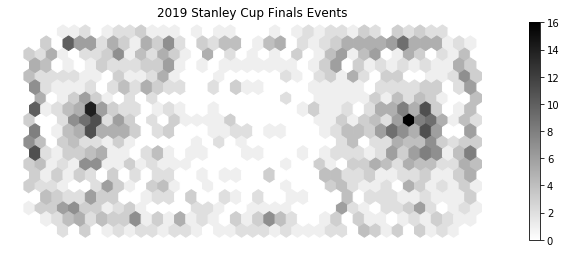

In [4]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

#open all events
df = pd.read_csv('2019SCF_events.csv')
events_lat = df.Lat
events_lon = df.Lon
locations_name = df.Description

#Convert strings to float
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
df['Lon'] = pd.to_numeric(df['Lon'], errors='coerce')

# Remove faceoffs
no_faceoffs = df['Event'] != "Faceoff"
# # Show as example
# print(df[faceoff])

g = df["Event"] =="Giveaway"

t = df["Event"] =="Takeaway"

# # print(df.dtypes)

# Creating dataframe for lat/Lon
df_hex = pd.DataFrame({'x': df.Lat,'y': df.Lon})

# creates hexbin plot from df_hex and removes faceoffs
ax1 = df_hex[no_faceoffs].plot.hexbin(x='x', y='y', gridsize=[40,9], cmap="gist_yarg", figsize=(11, 4))
ax1

# ax2 = df_hex[g].plot.hexbin(x='x', y='y', gridsize=[40,9], cmap="cividis", figsize=(11, 4))
# ax2

# ax3 = df_hex[t].plot.hexbin(x='x', y='y', gridsize=[40,9], cmap="cividis", figsize=(11, 4))
# ax3

#multiple hexbins (https://matplotlib.org/3.1.0/gallery/statistics/hexbin_demo.html)
# fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 2))

# resize figure option 1
# fig.set_size_inches([11, 2],forward=True)

# resize figure option 2
# fig= plt.figure(figsize=(10,3))


#Turn off gridlines and axis labels (putting at end shows extent)
ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')

# # df.style.set_properties(**{'background-color': 'black',
# #                            'color': 'lawngreen',
# #                            'border-color': 'white'})

ax1.set_title("2019 Stanley Cup Finals Events")

# ax2.set_title("Giveaways")

# ax3.set_title("Takeaways")

# Saves plot to image
plt.savefig('mytable.png', transparent = True)


# Converts white pixels into transparency
# https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent

img = Image.open('mytable.png')
img = img.convert("RGBA")
datas = img.getdata()

newData = []
for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)

img.putdata(newData)
img.save("mytable.png", "PNG")

# Horizontal Colorbar (Filtering?)

# Mapbox & Plotly

In [7]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
mapbox_access_token = open("mapbox_token.txt").read() # Create a local file with mapbox token

# These are just another way to write df = pd.read
# events = pd.read_csv("all_series_events.csv")
# fig = px.scatter_mapbox(events, 
#                         lat="Lat", 
#                         lon="Lon", 
# #                         hover_name="City", 
# #                         hover_data=["State", "Population"],
#                         color_discrete_sequence=["fuchsia"], zoom=12, height=300)

df = pd.read_csv('2019SCF_events.csv')

# All Events
events_lat = df.Lat
events_lon = df.Lon
locations_name = df.Description

# Team Events
STL = df[df['Team'].str.contains('St. Louis Blues')]
STL_lat = df[df['Team'].str.contains('St. Louis Blues')]['Lat']
STL_lon = df[df['Team'].str.contains('St. Louis Blues')]['Lon']
STL_text = df[df['Team'].str.contains('St. Louis Blues')]['Description']

BOS = df[df['Team'].str.contains('Boston Bruins')]
BOS_lat = df[df['Team'].str.contains('Boston Bruins')]['Lat']
BOS_lon = df[df['Team'].str.contains('Boston Bruins')]['Lon']
BOS_text = df[df['Team'].str.contains('Boston Bruins')]['Description']

# Display Data for Hits
hits = df[df['Event'].str.contains('Hit')]
hits_lat = df[df['Event'].str.contains('Hit')]['Lat']
hits_lon = df[df['Event'].str.contains('Hit')]['Lon']
hits_text = df[df['Event'].str.contains('Hit')]['Description']

# Display Data for Faceoffs
faceoff = df[df['Event'].str.contains('Faceoff')]
faceoff_lat = df[df['Event'].str.contains('Faceoff')]['Lat']
faceoff_lon = df[df['Event'].str.contains('Faceoff')]['Lon']
faceoff_text = df[df['Event'].str.contains('Faceoff')]['Description']

# Display Data for Shots
shots = df[df['Event'].str.contains('Shot')]
shots_lat = df[df['Event'].str.contains('Shot')]['Lat']
shots_lon = df[df['Event'].str.contains('Shot')]['Lon']
shots_text = df[df['Event'].str.contains('Shot')]['Description']

# Display Data for Penalties rgb(0, 255, 0)
penalties = df[df['Event'].str.contains('Penalty')]
pen_lat = df[df['Event'].str.contains('Penalty')]['Lat']
pen_lon = df[df['Event'].str.contains('Penalty')]['Lon']
pen_text = df[df['Event'].str.contains('Penalty')]['Description']

# Display Data for Giveaways rgb(51, 0, 0)
giveaway = df[df['Event'].str.contains('Giveaway')]
give_lat = df[df['Event'].str.contains('Giveaway')]['Lat']
give_lon = df[df['Event'].str.contains('Giveaway')]['Lon']
give_text = df[df['Event'].str.contains('Giveaway')]['Description']

# Display Data for Takeaways rgb(51, 0, 0)
takeaway = df[df['Event'].str.contains('Takeaway')]
take_lat = df[df['Event'].str.contains('Takeaway')]['Lat']
take_lon = df[df['Event'].str.contains('Takeaway')]['Lon']
take_text = df[df['Event'].str.contains('Takeaway')]['Description']


fig = go.Figure()

# All Events Markers
fig.add_trace(go.Scattermapbox(
        lat=events_lat,
        lon=events_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text',
        name="All Events"
    ))

# BOS Events Markers
fig.add_trace(go.Scattermapbox(
        lat=BOS_lat,
        lon=BOS_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=20,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=STL_text,
        hoverinfo='text',
        name="BOS"
    ))

# STL Events Markers
fig.add_trace(go.Scattermapbox(
        lat=STL_lat,
        lon=STL_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=20,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=STL_text,
        hoverinfo='text',
        name="STL"
    ))


# Hits Markers
fig.add_trace(go.Scattermapbox(
        lat=hits_lat,
        lon=hits_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(255,255,0)',
            opacity=0.7
        ),
        text=hits_text,
        hoverinfo='text',
        name="Hit"
    ))

# Faceoff Markers
fig.add_trace(go.Scattermapbox(
        lat=faceoff_lat,
        lon=faceoff_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(255,165,0)',
            opacity=0.7
        ),
        text=faceoff_text,
        hoverinfo='text',
        name="Faceoff"
    ))

# Shots Markers
fig.add_trace(go.Scattermapbox(
        lat=shots_lat,
        lon=shots_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 0, 255)',
            opacity=0.7
        ),
        text=shots_text,
        hoverinfo='text',
        name="Shot"
    ))

# Penalty Markers
fig.add_trace(go.Scattermapbox(
        lat=pen_lat,
        lon=pen_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 255, 000)',
            opacity=0.7
        ),
        text=pen_text,
        hoverinfo='text',
        name="Penalty"
    ))

# Giveaway Markers
fig.add_trace(go.Scattermapbox(
        lat=give_lat,
        lon=give_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(51, 000, 000)',
            opacity=0.7
        ),
        text=give_text,
        hoverinfo='text',
        name="Giveaway"
    ))

# Takeaway Markers
fig.add_trace(go.Scattermapbox(
        lat=take_lat,
        lon=take_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(51, 000, 000)',
            opacity=0.7
        ),
        text=take_text,
        hoverinfo='text',
        name="Takeaway"
    ))


fig.update_layout(
    title='Events',
    autosize=True,
    hovermode='closest',
    showlegend=True,
#     legend_title='<b> Layers </b>',
    legend_orientation="h",
        legend=dict(
        x=.1,
        y=1.2,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=16,
            color="black"
        ),
        bgcolor="white",
        bordercolor="Black",
        borderwidth=2
    ),
    mapbox=dict(
        accesstoken=mapbox_access_token,
        center=dict(
            lat=0,
            lon=0
        ),
        pitch=0,
        zoom=1,
        bearing=0,
        style='mapbox://styles/isaacv/ck9n5j6ch0h6p1immcg0dc3hr'
    ),
)

# Need bounds and max zoom

fig.update_layout(margin={"r":20,"t":20,"l":20,"b":20})



final = fig.show()
print(final)

None
